In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import sys
sys.path.append("..")

from src.utils import add_zero
from src.utils import fix_colnames

In [2]:
pd.options.display.max_columns = None

The following function comes from `01-data-exploration` notebook:

In [3]:
def process_date(df: pd.DataFrame):
    """
    This function aims to build the date variable with the format %Y-%m-%d %H:%M
    
    Arguments
    ---------
    df (pd.DataFrame): raw data
    
    Return
    ------
    data (pd.DataFrame): data with date processed
    """
    
    data = df.copy()
    
    # Build date column: format Y-m-d H:m
    data["month"] = data["month"].apply(add_zero)
    data["day"]   = data["day"].apply(add_zero)
    data["hour"]  = data["hour"].apply(add_zero)

    date_str = (
        data["year"].astype(str) + "-" + 
        data["month"] + "-" + 
        data["day"] + " " + 
        data["hour"] + ":00"
    )
    data["date"] = pd.to_datetime(date_str)
    data["day_name"] = data["date"].dt.strftime("%a")
    data = data.drop(columns = ["year", "month", "day"])
    
    return data

def process_data(df: pd.DataFrame):
    """
    This function aims to process the raw data
    
    Arguments
    ---------
    df (pd.DataFrame): raw data
    
    Return
    ------
    data (pd.DataFrame): data processed    
    """    
    data = df.copy()
    
    data.columns = fix_colnames(data.columns)
    data = process_date(data)    
    
    data = data.dropna(subset=["pm2_5"])
    
    # cbwd has these categories: SE, NW, NE and cv
    # we can suppose that cv is SW
    data["cbwd"] = data["cbwd"].replace({"cv": "SW"})

    # drop useless columns
    cols_drop = ["no"]
    data = data.drop(columns=cols_drop)
    
    data = data.set_index("date")
    
    return data

### Load data

In [4]:
df = pd.read_csv("../data/PRSA_data_2010.1.1-2014.12.31.csv")

In [5]:
df_prd = process_data(df)

### Feature engineering

One useful thing when we have cyclical features like the hour is to use the transformation sine and cosine.

In [6]:
# Sine and cosine representation - source: 
# https://www.cienciadedatos.net/documentos/py39-forecasting-series-temporales-con-skforecast-xgboost-lightgbm-catboost.html
df_prd["hour"] = df_prd["hour"].astype(int)
df_prd['hour_sin'] = np.sin(df_prd['hour'] / 23 * 2 * np.pi)
df_prd['hour_cos'] = np.cos(df_prd['hour'] / 23 * 2 * np.pi)

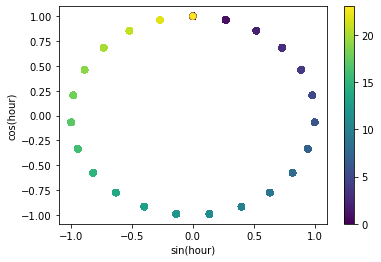

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
sp = ax.scatter(df_prd["hour_sin"], df_prd["hour_cos"], c=df_prd["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

OneHotEncoder for qualitative features

In [9]:
quali_feat = ["cbwd", "day_name"]

enc = OneHotEncoder()
enc.fit(df_prd[quali_feat])

one_hot_arr = enc.transform(df_prd[quali_feat]).toarray()

labels = [x for sublist in enc.categories_ for x in sublist]
one_hot_df = pd.DataFrame(one_hot_arr, columns=labels, index=df_prd.index)

df_prd = df_prd.join(one_hot_df)

Due that we want to forecast one month ahead, we can't use `dewp`, `temp`, `pres`, `iws`, `is`and `ir`, because we don't have these features in the future. If we would want to use these feature we would have to build one model by feature in order to forecast them.

In [10]:
cols_to_drop = quali_feat + \
               ["dewp", "temp", "pres", "iws", "is", "ir", "hour", "cbwd", "day_name"]

df_prd = df_prd.drop(columns=cols_to_drop)

In [11]:
print(df_prd.shape)
df_prd.head()

(41757, 14)


,pm2_5,hour_sin,hour_cos,NE,NW,SE,SW,Fri,Mon,Sat,Sun,Thu,Tue,Wed
date,,,,,,,,,,,,,,
2010-01-02 00:00:00,129.0,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2010-01-02 01:00:00,148.0,0.269797,0.962917,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2010-01-02 02:00:00,159.0,0.519584,0.854419,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2010-01-02 03:00:00,181.0,0.730836,0.682553,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2010-01-02 04:00:00,138.0,0.887885,0.460065,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Train - Validation - Test split

We are going to use one month as validation and the last month as test dataset

In [16]:
def train_val_test_split(df, n_months_test=1):
    
    data = df.copy()
    
    min_date  = data.index.min()
    max_date  = data.index.max()

    val_date  = max_date - relativedelta(months = (n_months_test+1))
    test_date = max_date - relativedelta(months = n_months_test)
    
    train = data[data.index <= val_date]
    val   = data[(data.index > val_date) & (data.index <= test_date)]
    test  = data[data.index > test_date]

    print("Train shape: {} from: {} to: {}".format(train.shape, train.index.min(), train.index.max()))
    print("  Val shape: {} from: {} to: {}".format(val.shape, val.index.min(), val.index.max()))
    print(" Test shape: {} from: {} to: {}".format(test.shape, test.index.min(), test.index.max()))

    return train, val, test

In [17]:
train, val, test = train_val_test_split(df_prd)

Train shape: (40335, 14) from: 2010-01-02 00:00:00 to: 2014-10-31 23:00:00
  Val shape: (706, 14) from: 2014-11-01 00:00:00 to: 2014-11-30 23:00:00
 Test shape: (716, 14) from: 2014-12-01 00:00:00 to: 2014-12-31 23:00:00


In [18]:
print(train.shape)
train.head()

(40335, 14)


,pm2_5,hour_sin,hour_cos,NE,NW,SE,SW,Fri,Mon,Sat,Sun,Thu,Tue,Wed
date,,,,,,,,,,,,,,
2010-01-02 00:00:00,129.0,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2010-01-02 01:00:00,148.0,0.269797,0.962917,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2010-01-02 02:00:00,159.0,0.519584,0.854419,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2010-01-02 03:00:00,181.0,0.730836,0.682553,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2010-01-02 04:00:00,138.0,0.887885,0.460065,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
train.to_csv("../data/train.txt", sep="|")
val.to_csv("../data/val.txt", sep="|")
test.to_csv("../data/test.txt", sep="|")

## References

https://www.cienciadedatos.net/documentos/py39-forecasting-series-temporales-con-skforecast-xgboost-lightgbm-catboost.html